In [1]:
library("tidyverse")
library("data.table")
library("cowplot")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
read_traj <- function(traj){
    tmp <- fread(traj)
    tmp[, frame_n := 1:.N]
    tmp[, id := basename(traj) |> str_remove("_traj_with_identities.csv.gz$")]
    tmp <- suppressWarnings(melt(tmp, id.vars = c("id", "frame_n")))
    tmp[, fish := str_remove(variable, "_.*$")]
    tmp[, variable := str_remove(variable, "^(ref|test)_")]
    tmp <- dcast(tmp, id + frame_n + fish ~ variable)
    return(tmp)
}

f_list <- list.files("/nfs/research/birney/users/saul/outputs/medaka_beahviour/medaka_behaviour_pilot/trajectories_csv/", full.names = TRUE)
df1 <- lapply(f_list, read_traj) |> rbindlist()

In [50]:
df2 <- fread("/nfs/research/birney/users/saul/outputs/medaka_beahviour/medaka_behaviour_pilot/hmm/time_step0.08_n_states15_hmm.csv.gz")

In [51]:
df2[, fish := str_remove(id, "^.*_")]
df2[, id := str_remove(id, "_(ref|test)")]
df2[, time_s := NULL]

In [52]:
df <- merge(df1, df2, all = TRUE)

In [53]:
df[, is_tracked := (!is.na(x) & !is.na(y))]

In [59]:
read_metrics <- function(f){
    tmp <- fread(f)[
        , .(
            id = basename(f) |> str_remove("_metrics.csv.gz$"),
            frame_n, time_s
        )
    ]
    return(tmp)
}

f_list <- list.files("/nfs/research/birney/users/saul/outputs/medaka_beahviour/medaka_behaviour_pilot/metrics/time_interval_0.08/", full.names = TRUE)
df3 <- lapply(f_list, read_metrics) |> rbindlist()

In [63]:
df <- merge(df, df3, by = c("id", "frame_n"), all = TRUE)

In [78]:
summary <- df[
    order(frame_n),
    .(
        frame_n,
        segment_0.08 = vctrs::vec_fill_missing(time_s, direction = "up"),
        is_tracked,
        id_prob,
        distance
    ),
    by = c("id", "fish")
][
    , segment_1 := floor(segment_0.08/1)
][
    , .(
        mean_dist = mean(distance, na.rm = TRUE),
        p_tracked = mean(is_tracked)
    )
    , by = c("id", "fish", "segment_1")
]

In [122]:
df[, segment := floor(time_s/1)]

In [138]:
summary <- df[
    , .(
        mean_id_prob = mean(id_prob),
        mean_dist = mean(distance, na.rm = TRUE),
        p_tracked = mean(is_tracked)
    ),
    by = .(id, fish, segment)
]

In [147]:
df[is_tracked == TRUE & !is.na(id_prob), range(id_prob)]

[1] 1 1

In [157]:
df[, round(mean(!is_tracked) * 100, 2)]

[1] 0.57

In [152]:
df[is_tracked == FALSE, mean(is.na(id_prob))]

[1] 0.9946571

In [139]:
summary[, 100 - round(mean(is.na(mean_dist)) * 100, 2)]

[1] 99.63

In [125]:
cor(summary[["mean_dist"]], summary[["p_tracked"]], method = "spearman", use = "complete.obs") |> signif(1)

[1] -3e-04

Warning message:
“Removed 2720 rows containing non-finite outside the scale range
(`stat_binhex()`).”


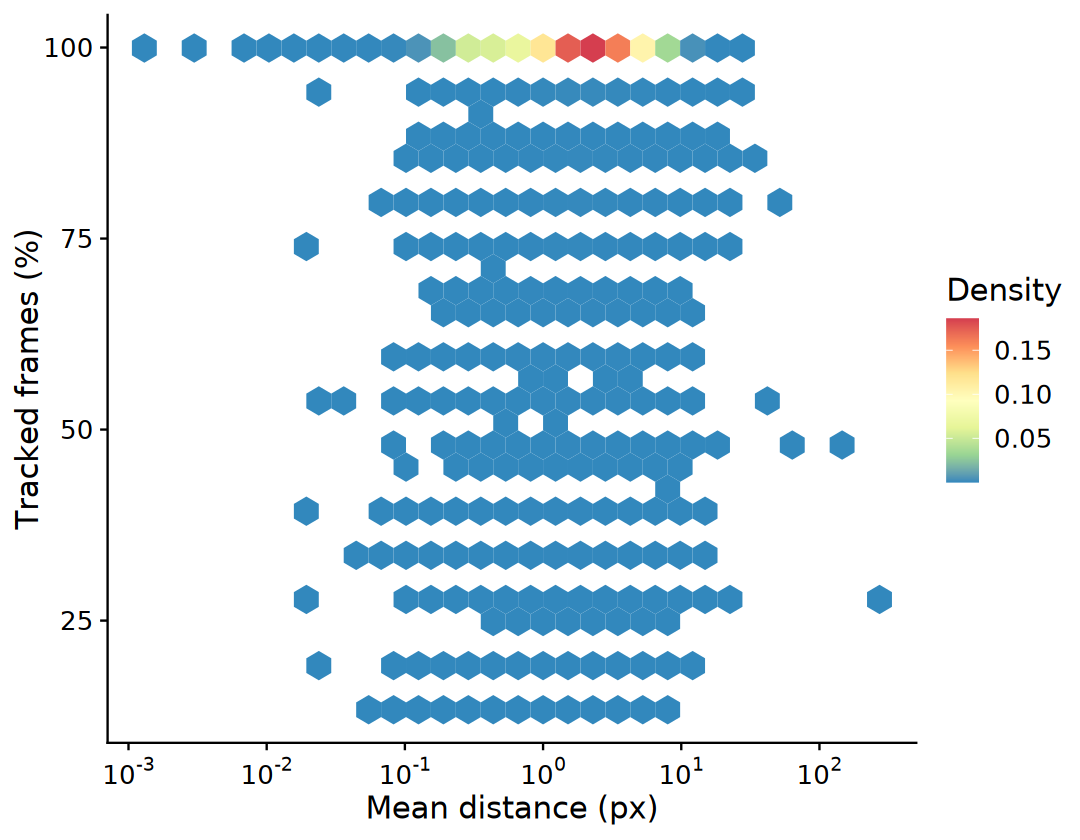

In [135]:
options(repr.plot.width = 9, repr.plot.height = 7)
ggplot(summary, aes(x = log10(mean_dist), y = p_tracked*100, fill = after_stat(density))) +
    geom_hex(bins = 30) +
    scale_fill_distiller(palette = "Spectral") +
    labs(x = "Mean distance (px)", y = "Tracked frames (%)", fill = "Density") +
    scale_x_continuous(labels = scales::label_math()) +
    theme_cowplot(18) +
    theme(legend.box.margin = unit(0.2, "cm"))